In [1]:
import numpy as np
# Convert a collection of raw documents to a matrix of TF-IDF features.
# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt

%matplotlib inline
%config InlineBackend.firgure_format = "retina"

# import WenShuan class
from WenShuan import WenShuan

import re

## LDA -- n-grams feature extraction in sklearn

I found an interesting function in `sklearn` that allow user to extract features from text data -- `CountVectorizer`. 

In our case, we are interested in classical Chinese text data, which usually do not have a decent sentence segmentation implement (at least there are no such __off-shelf__ implementation to use.)

So, other than sentence segmentation, people usually use n-grams to see the frequency of the conjuctions of characters. If there is a high-frequency character conjunction in the classical text, we usually think these conjunction are features. 

The preprocessing of LDA must be done by feature extraction. And `CountVectorizer` is a efficient function to extract different n-grams at one time.

The reference for LDA and usage of `CountVectorizer` please find `PyMC3` tutorial [Automatic autoencoding variational Bayes for latent dirichlet allocation with PyMC3](http://docs.pymc.io/notebooks/lda-advi-aevb.html)

### Loading Data

If would use our Han-Ji data organizer to load 文選. If you don't want to use our Han-Ji organizer or you don't have the access to Han-Ji sinica database, you can try to scrape wikisource [昭明文選](https://zh.wikisource.org/zh-hant/昭明文選).

In [4]:
wenshuan = WenShuan("2018-07-05", "MF")
wenshuan.load_htmls()

# organize the text files 
wenshuan.extract_paths()         # extract the bookmarks
wenshuan.get_author_bag()        # get the bag of author names and comments
wenshuan.extract_meta()          # extract the meta data
wenshuan.passages2tuples()       # get the passsage into (text, comment) tuples
wenshuan.heads2tuples()          # get headers into (head, comment, ...) tuples
wenshuan.extract_commentators()  # append commentators to metadata
wenshuan.extract_sound_glosses() # append all sound glosses in comments into a list and remove them from the self.flat_passages

[Info] Stop at loading data/wenshuan_0582.html.
[Info] Total length of the data is 582.
[Warning] No author name in 47 item, but got a tag. Attach this tag to previous author name 陸士衡.
[Warning] No author name in 53 item, but got a tag. Attach this tag to previous author name 王子淵.
[Warning] No author name in 62 item, but got a tag. Attach this tag to previous author name 曹子建.
[Warning] No author name in 88 item, but got a tag. Attach this tag to previous author name 丘希範.
[Warning] No author name in 95 item, but got a tag. Attach this tag to previous author name 謝玄暉.
[Warning] No author name in 111 item, but got a tag. Attach this tag to previous author name 應璩.
[Warning] No author name in 117 item, but got a tag. Attach this tag to previous author name 魏文帝.
[Warning] No author name in 187 item, but got a tag. Attach this tag to previous author name 劉越石.
[Warning] Author name, 飲馬長城窟行 in 244, is too long. Discard this one.
[Warning] No author name in 244 item, but got a tag. Attach this 

In [5]:
# arrage text to chapters in a list (and get rid of puctuations)
full_text = [re.sub(
    r"[ ，、。？﹖！：；「」〔〕『』]",
    "",
    ''.join([passage for passage,comment in passages]),
    )
    for passages in wenshuan.flat_passages
]

### N- Grams Extraction

The usual way to extract n-gram is to use `Counter`. 

I would show you first with `Counter` and demonstrate the usage of `CountVectorizer`.

In [8]:
# Option A: using Counter 
from collections import Counter

one_gram = Counter("\n".join(full_text))

In [9]:
one_gram.most_common(10)

[('之', 7773),
 ('而', 3845),
 ('以', 3496),
 ('不', 3227),
 ('於', 2248),
 ('其', 2083),
 ('兮', 1677),
 ('有', 1561),
 ('為', 1373),
 ('無', 1331)]

In [11]:
# Option B: using sklearn CountVectorizer
count = CountVectorizer(ngram_range=(1,1), max_features=10, analyzer="char")
trans = count.fit_transform(full_text)

Here, the function arguments:
- `ngram_range`: the range of n_gram you want to include, it should be a tuple. E.g., if you want to have 2-gram to 4-gram, you can set `ngram_range = (2, 4)`
- `max_feature` : features with top-N frequency you want to consider.
- `analyzer`: set to `char` for character based n-grams.

In [19]:
count.get_feature_names()

['不', '之', '以', '兮', '其', '於', '有', '為', '無', '而']

In [20]:
set(count.get_feature_names()) == {x for x,_ in one_gram.most_common(10)}

True

It is the same as the result of `Counter`.

### 2 gram to 5 gram

One gram is not so interesting because it is rather difficult to know what does it means simply use one-gram. Chinese words are usually constituted with 2 or more characters, e.g., "聖人", "大道", "金風玉露".

In [22]:
count = CountVectorizer(ngram_range=(2,5), max_features=1000, analyzer="char")
trans = count.fit_transform(full_text)

Preview the features.

In [25]:
print(count.get_feature_names()[::5])

['一也', '一時', '三年', '上有', '下無', '不可', '不如', '不忘', '不朽', '不知', '不足', '且夫', '丞相', '主上', '之上', '之乎', '之以', '之倫', '之制', '之名', '之在', '之外', '之妙', '之將', '之徒', '之思', '之所以', '之日', '之有', '之極', '之流', '之生', '之神', '之罪', '之聲', '之與', '之行', '之變', '之道', '之際', '之餘', '乎夫', '也且', '也子', '也是', '也至', '于時', '亦既', '人之所', '人情', '仁義', '以下', '以娛', '以為', '以至', '何不', '何為', '作者', '侯之', '先帝', '光武', '公孫', '兮哀', '其上', '其後', '其流', '其若', '其間', '則不', '化之', '十餘', '千金', '參差', '古之', '可得', '各有', '君臣', '周流', '命也', '哉故', '嗚呼哀哉', '四海', '在天', '士之', '大人', '天下', '天命', '天道', '夫之', '失其', '如故', '子之', '孔子', '安得', '容與', '寥廓', '尚書', '山\uf6a4', '川之', '已哉', '常之', '年之', '往而', '得其', '從容', '德以', '心於', '忘歸', '惆悵', '我心', '所不', '所能', '故其', '文之', '文章', '於上', '於南', '於是', '於無', '日之', '明主', '明月', '是以', '時之', '曰天', '月之', '有大', '有餘', '木之', '未有', '東方', '楚之', '歌曰', '武皇', '死罪死', '水之', '泰山', '海之', '清風', '為一', '為大', '無事', '無為', '然則', '爾乃', '物而', '王侯', '甘泉', '用之', '疇昔', '白露', '百里', '盡其', '矣夫', '社稷', '秋之', '立功', '終日', '罔不', '群后', '翼翼', '者以', '者皆', '而不', '而來',

Many of them are stop words in classical Chinese, like `[之, 而, 於, 其, 以, 且, 乎, 夫, 也]`

It is also quite amusing that "天道", "天下", "仁義" can be extracted from the text in this automatic way.

`CountVectorizer` also allow us to know the which features are in a chapter. The first dimension represents the chapter number, the second dimension represent the count of the feature numbers.

In [28]:
# the shape of the array
trans.toarray().shape

(582, 1000)

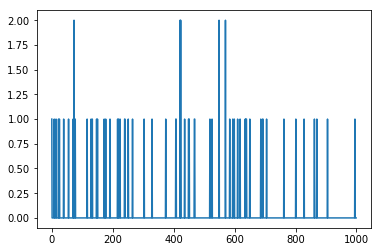

In [32]:
# the first chapter
plt.plot(trans.toarray()[0])

In [37]:
# those feature are in the first chpater
first_chapter_features = np.array(count.get_feature_names())[
    trans.toarray()[0].nonzero()
]
first_chapter_features

array(['一也', '三代', '上之', '不以', '不可', '不暇', '且夫', '之上', '之世', '之事', '之屬',
       '之所', '之文', '之歌', '之流', '之臣', '之舊', '之遺', '也故', '也昔', '也臣', '人之',
       '人之所', '今之', '以為', '公卿', '其義', '司馬', '國家', '國家之', '大夫', '大漢', '太子',
       '如彼', '如此', '宮室', '家之', '從之', '德而', '或以', '文章', '於後', '日不', '日月',
       '是以', '時而', '有餘', '望之', '朝夕', '朝廷', '東方', '海內', '漢之', '漢室', '無事',
       '相如', '者不', '而後', '臣之', '至於', '詩書', '龍之'], dtype='<U4')

In [43]:
# Viz them in the full text
from IPython.display import HTML

first_chapter = "".join([x for x,_ in wenshuan.flat_passages[0]])

for feature in first_chapter_features:
    first_chapter = re.sub( r"({})".format(feature), r"<font color='#9999ff'>\1</font>", first_chapter)
    
HTML(first_chapter)    

### How to deal with stop words?

`CountVectorizer` currently do not support stop words for `char` based n-grams. Maybe it is one thing I can contribute for this function. However, let's try out just simply exclude them from our features.

In [44]:
count = CountVectorizer(ngram_range=(2,5), max_features=1000, analyzer="char")
trans = count.fit_transform(full_text)

In [59]:
features = count.get_feature_names()
features = [f for f in features if len(re.findall(r"[惟可所若有哉在如何故者孰矣于兮豈則又不為之而於其以且乎夫也]", f))  == 0]
print(features)

['一人', '一日', '一旦', '一時', '一朝', '一言', '三代', '三十', '三年', '三王', '三軍', '上下', '上林', '下無', '世祖', '丞相', '中書', '中興', '主上', '主人', '九州', '二十', '云爾', '五千', '五帝', '亦既', '人主', '人事', '人情', '人曰', '人生', '仁義', '今日', '仲尼', '伊尹', '佳人', '來歸', '侍中', '侍郎', '俯仰', '偃蹇', '兄弟', '先帝', '先王', '先生', '光武', '公卿', '公子', '公孫', '六合', '出入', '刺史', '功名', '區區', '十二', '十餘', '千乘', '千仞', '千載', '千里', '千金', '升降', '南山', '原隰', '參差', '受命', '古人', '古今', '司徒', '司馬', '君子', '君臣', '吾子', '周公', '周流', '呼哀', '唐虞', '嗚呼', '嗚呼哀', '四十', '四方', '四時', '四海', '國家', '士女', '多士', '夜光', '大人', '大將', '大漢', '大王', '天下', '天人', '天命', '天地', '天子', '天道', '太子', '太子曰', '太守', '太祖', '妻子', '始皇', '子孫', '子弟', '子曰', '孔子', '存亡', '宇宙', '安得', '宋玉', '客曰', '宮室', '容與', '寂寥', '富貴', '寒暑', '寡人', '寥廓', '將軍', '對曰', '小人', '尚書', '屈原', '山川', '山\uf6a4', '峨峨', '崑崙', '崢嶸', '巍巍', '州刺', '州刺史', '左右', '帝王', '常侍', '平原', '平生', '庶幾', '弭節', '弱冠', '往來', '後世', '後宮', '得失', '徘徊', '從容', '微子', '志士', '忘歸', '忠臣', '性命', '悠悠', '悲風', '惆悵', '感物', '慷慨', '成敗', '我心', '我王', '我皇', '承明', '攜手', '文學', '文武', '文王', '

From 3-gram to 5-gram

In [60]:
count = CountVectorizer(ngram_range=(3,5), max_features=1000, analyzer="char")
trans = count.fit_transform(full_text)

In [61]:
features = count.get_feature_names()
features = [f for f in features if len(re.findall(r"[惟可所若有哉在如何故者孰矣于兮豈則又不為之而於其以且乎夫也]", f))  == 0]
print(features)

['三十載', '中常侍', '中書監', '中郎將', '丹陽尹', '主人曰', '乃相與', '事然後', '二十八', '二十餘', '二十餘年', '些歸來', '些歸來歸', '些歸來歸來', '亦天下', '人君子', '人贈我', '今吾子', '今天下', '今陛下', '佇立望', '余病未', '余病未能', '作誄曰', '作頌曰', '使持節', '使持節都', '使持節都督', '來歸來', '僕病未', '僕病未能', '先生曰', '克明克', '公子曰', '公子曰余', '公子曰余病', '十二日', '十餘年', '千載一', '千里遊', '卒嗚呼', '卒嗚呼哀', '南徐州', '叔孫通', '古來共', '右長史', '司馬相', '君子道', '品物咸', '嗚呼哀', '國中屬', '塊然獨', '填溝壑', '士文王', '多歷年', '大司馬', '大將軍', '大王熟', '大王熟察', '天下大', '天下安', '天下歸', '天下無', '天下笑', '天子乃', '太子曰', '太子曰僕', '太子曰僕病', '太子能', '太子能彊', '太子能彊起', '夾杖龍', '夾杖龍牽', '奴教子', '婢采音', '子曰予', '子曰余', '子曰余病', '子曰余病未', '子曰僕', '子曰僕病', '子曰僕病未', '子能彊', '子能彊起', '子能從', '子能從我', '宋玉對', '宋玉對曰', '寡人賦', '尚書令', '巍巍蕩', '巍巍蕩蕩', '巍蕩蕩', '州刺史', '州諸軍', '州諸軍事', '帝三王', '引領望', '微子曰', '微子曰予', '思曰我', '悠悠我', '惶誠恐', '憂心煩', '應天順', '懷憂心', '懷憂心煩', '成一家', '我高祖', '持節都', '持節都督', '挹飛泉', '攜手同', '散騎常', '散騎常侍', '文學曰', '文皇帝', '方朔枚', '方朔枚臯', '日已遠', '日\uf6a3\uf5ea', '春秋三', '春秋三十', '是用錫', '是用錫君', '時天下', '曰余病', '曰余病未', '曰余病未能', '曰僕病', '曰僕病未', '曰僕病未能', '曰唯唯', '曰天下', '曰寡人',

Next time, I would try to implement stop words in `CountVectorizer`. Maybe next time's next time we would have a chance to implement LDA...


(to be continue...)